In [4]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import pandas as pd
import numpy as np
import requests
import zipfile
import glob

from parse_reference_spectra import parse_gnps_json, output_loop
from spectra_to_sirius import master_loop
from clone_ds_to_beta import copy_beta
from results_from_metaspace_msms_process import logon_metaspace
from metaspace.sm_annotation_utils import SMInstance
from results_from_metaspace_msms_process import split_data_frame_list
from sirius_to_metaspace_db import primary_loop
from cosine_spectra import score_alignment, read_ms_file
import matplotlib.pyplot as plt

Workflow steps on spotted standards for METASAPCE MS/MS publication.

In [ ]:
# 1. Authentic standard compounds of interest (COI's).
spotted_cmpds_df = pd.read_csv('input/spotted_cmpds.csv', sep="\t")

In [ ]:
### not now ###
# 2. Downloading database references: GNPS
# Academic users only: contact "ccms-web@cs.ucsd.edu" and request "gnps_exp_all.json"
# Copy to "intermdiate/gnps_exp_all.json"
gnps_df = parse_gnps_json('intermdiate/gnps_exp_all.json')
gnps_df.to_pickle('intermediate/databases/gnps_df.pickle')

In [ ]:
### not now ###
# 2. Downloading database references: HMDB 
with open('intermediate/hmdb_experimental_msms_spectra.zip', 'wb') as f:
    f.write(requests.get('http://specdb.wishartlab.com/downloads/exports/spectra_xml/hmdb_experimental_msms_spectra.zip', allow_redirects=True).content)
with zipfile.ZipFile('intermediate/hmdb_experimental_msms_spectra.zip', 'r') as z:
    z.extractall('intermediate/hmdb_lcms/hmdb_experimental_msms_spectra/')
    
with open('intermediate/hmdb_predicted_msms_spectra.zip', 'wb') as f:
    f.write(requests.get('http://specdb.wishartlab.com/downloads/exports/spectra_xml/hmdb_predicted_msms_spectra.zip', allow_redirects=True).content)
with zipfile.ZipFile('intermediate/hmdb_predicted_msms_spectra.zip', 'r') as z:
    z.extractall('intermediate/hmdb_lcms/hmdb_predicted_msms_spectra/')

!python hmdb_parser.py --input intermediate/hmdb_lcms/ --output intermediate/databases/ --polarity both

In [ ]:
### not now ###
# 2. Downloading database references: MONA
!python query_mona.py --input input/core_metabolome_v3.pickle --output intermediate/databases/ --polarity negative
!python query_mona.py --input input/core_metabolome_v3.pickle --output intermediate/databases/ --polarity positive

In [ ]:
# 3. Collecting predicted MS/MS spectra for spotted compounds
ref_theo_pos = 'input/reference_spectra/positive_theoretical'
ref_theo_neg = 'input/reference_spectra/negative_theoretical'

In [ ]:
# 4. Collecting reference experimental MS/MS spectra for spotted compounds
ref_expt_pos = 'input/reference_spectra/positive_experimental'
ref_expt_neg = 'input/reference_spectra/negative_experimental'

In [ ]:
# 5. Collecting in-house experimental MS/MS spectra for spotted compounds
embl_expt_pos = 'input/reference_spectra/embl_maldi/positive'
embl_expt_neg = 'input/reference_spectra/embl_maldi/negative'

## Parse to [(mz,int),..]

In [ ]:
# 6. Generating custom MS1 database using known spotted compounds.
cm3_df = pd.read_pickle('input/core_metabolome_v3.pickle')
cm3_stds_df = cm3_df[cm3_df.id.isin(list(spotted_cmpds_df.id))].copy(deep=True)

In [ ]:
### not now ###
# 7. Running and interpreting the METASPACE results.
spotted_ds_id_in = {'id_1': 'positive', 'id_n': 'negative'}
out_dict_list = []
for ds, polarity in spotted_ds_id_in.items():
    if polarity == 'positive':
        x = copy_beta(ds, 'HNaKM', 'cm3_stds')
    elif polarity == 'negative':
        x = copy_beta(ds, 'HM', 'cm3_stds')
    out_dict_list.append(x)
    
out_df = pd.DataFrame(out_dict_list)
out_df.to_pickle('cm3_spotted_msms_df.pickle')

# Check that jobs are complete on server before running next cell
## Update list of dataset ids after experiment ran

In [ ]:
### not now ###
# 7. Running and interpreting the METASPACE results.
df_list = []
for ms_ds_id in out_df.ds_id_out:
    ds_id_in = list(out_df[out_df.ds_id_out == ms_ds_id].ds_id_in)[0]
    sm = SMInstance(host='https://beta.metaspace2020.eu')
    sm = logon_metaspace(sm)
    ds = sm.dataset(id=ms_ds_id)
    results_df = ds.results(database='cm3_stds').reset_index()
    results_df['ds_id_in'] = ds_id_in
    df_list.append(results_df)

ms1_df = pd.concat(df_list)
ms1_df = ms1_df[ms1_df.fdr <=0.2]
ms1_df = ms1_df[['ds_id_in', 'moleculeIds']]
ms1_df = split_data_frame_list(ms1_df, 'moleculeIds')

## Plot MS1 figures here for standards to folder.
## Need ds_id first!

In [ ]:
### not now ###
# 8. Generating custom MS2 database using known spotted compounds.
gnps_exp_all = 'intermdiate/gnps_exp_all.json'
hmdb_exp_negative = 'intermediate/databases/hmdb_exp_negative.pickle'
hmdb_exp_positive = 'intermediate/databases/hmdb_exp_positive.pickle'
hmdb_theo_negative = 'intermediate/databases/hmdb_theo_negative.pickle'
hmdb_theo_positive = 'intermediate/databases/hmdb_theo_positive.pickle'
mona_exp_negative = 'intermediate/databases/mona_exp_negative.pickle'
mona_exp_positive = 'intermediate/databases/mona_exp_positive.pickle'

# Generate reference database limited to cmpds with theo/exp spectra
output_loop(cm3_stds_df,
            'intermediate/databases/',
            gnps_exp_all,
            hmdb_exp_positive,
            hmdb_exp_negative,
            hmdb_theo_positive,
            hmdb_theo_negative,
            mona_exp_positive,
            mona_exp_negative
           )

# Parses spectra from databases and runs Sirius
master_loop('intermediate/databases/ref_expt_df.pickle',
            'intermediate/sirius_out/',
            gnps_exp_all,
            hmdb_exp_positive,
            hmdb_exp_negative,
            hmdb_theo_positive,
            hmdb_theo_negative,
            mona_exp_positive,
            mona_exp_negative,
            'positive',
            'exp'
           )

master_loop('intermediate/databases/ref_expt_df.pickle',
            'intermediate/sirius_out/',
            gnps_exp_all,
            hmdb_exp_positive,
            hmdb_exp_negative,
            hmdb_theo_positive,
            hmdb_theo_negative,
            mona_exp_positive,
            mona_exp_negative,
            'negative',
            'exp'
           )

master_loop('intermediate/databases/ref_theo_df.pickle',
            'intermediate/sirius_out/',
            gnps_exp_all,
            hmdb_exp_positive,
            hmdb_exp_negative,
            hmdb_theo_positive,
            hmdb_theo_negative,
            mona_exp_positive,
            mona_exp_negative,
            'positive',
            'theo'
           )

master_loop('intermediate/databases/ref_theo_df.pickle',
            'intermediate/sirius_out/',
            gnps_exp_all,
            hmdb_exp_positive,
            hmdb_exp_negative,
            hmdb_theo_positive,
            hmdb_theo_negative,
            mona_exp_positive,
            mona_exp_negative,
            'negative',
            'theo'
           )

In [ ]:
### not now ###
# 8. Generating custom MS2 database using known spotted compounds.
for ds, polarity in spotted_ds_id_in.items():    
    primary_loop(list(cm3_stds_df.name.unique()),
                 ds,
                 'I_spotted_standards',
                 polarity,
                 'intermediate/sirius_out/exp_positive.pickle',
                 'intermediate/sirius_out/theo_positive.pickle',
                 'intermediate/sirius_out/exp_negative.pickle',
                 'intermediate/sirius_out/theo_negative.pickle',
                 'intermediate/databases/ref_expt_df.pickle',
                 'intermediate/databases/ref_theo_df.pickle'
                 )

In [ ]:
### not now ###
# 9. Running and interpreting the METASPACE MSMS results.
out_dict_list = []
for ds, polarity in spotted_ds_id_in.items():
    x = copy_beta(ds, 'M', 'ds')
    out_dict_list.append(x)
    
out_df = pd.DataFrame(out_dict_list)
out_df.to_pickle('I_spotted_standards/cm3_spotted_msms_df.pickle')

In [16]:
## Placeholder to develop plotting function below
## Downloads results for getting psuedo-MS/MS spectra from METASAPCE
from results_from_metaspace_msms_process import reporting_loop

reporting_loop('2020-03-12_17h55m21s',
               '2020-05-13_17h50m21s',
               '2020-05-14_16h32m01s',
               'TEMP_to_delete_pre_publish/reporting/',
               parent_and_fragment_req=True,
               fdr_max=0.5,
               save_image=False)

df = pd.read_pickle('TEMP_to_delete_pre_publish/reporting/2020-05-14_16h32m01s/ms2_2020-05-14_16h32m01s_db_2020-05-13_17h50m21s_ms1_2020-03-12_17h55m21s.pickle')

2020-05-14_16h32m01s  Counter:  11


In [28]:
## Annoates results with cosine
from results_processing_on_dl_results import annotate_cos_parent_fragment

df = annotate_cos_parent_fragment('TEMP_to_delete_pre_publish/reporting',
                                   ['2020-05-14_16h32m01s'], 
                                   'TEMP_to_delete_pre_publish/reporting/2020-05-14_16h32m01s/ms2_2020-05-14_16h32m01s_db_2020-05-13_17h50m21s_ms1_2020-03-12_17h55m21s.pickle')

1   2020-05-14_16h32m01s


In [ ]:
# from 'input_path/ms2_ds_id/*.pickle' can get x(mz) and y(binary, fdr, msm, int)
# to get: coloc from somewhere in existing code base
# masked intensity from Lachlan

In [ ]:
# 10. Generate psuedo-MS/MS spectra from ISF data.

## For results above write a function!  Use test df for now.
## Folders by ds_id, then group by hmdb_id
## x = mz, y = binary (annotated or not), FDR, MSM, Colocalization, 
## Intensity from total ion image, Masked intensity (above)

## To be implemented by someone else?
## Execute fxn(list(spotted_cmpds_df.id))

In [29]:
def spectral_encoder(df, ds_id, name, y_to_plot):
    # Generates a MS/MS spectra as [(mz, value)1...(mz, value)n]
    # where n maybe: "binary", "fdr", "msm", "coloc", "intensity"
    # or "specific_intensity".
    df = df[(df.ds_id == ds_id)&(df.id_x == name)]
    df = df.sort_values(by=['mz'])
    if y_to_plot == 'binary':
        return list(df.apply(lambda row: (row.mz, 1), axis=1))
    elif y_to_plot == 'fdr':
        return list(df.apply(lambda row: (row.mz, 1/row[y_to_plot]), axis=1))
    else:
        return list(df.apply(lambda row: (row.mz, row[y_to_plot]), axis=1))

In [31]:
test_bin = spectral_encoder(df, '2020-05-14_16h32m01s', 'HMDB0010382', 'binary')
test_fdr = spectral_encoder(df, '2020-05-14_16h32m01s', 'HMDB0010382', 'fdr')
test_msm = spectral_encoder(df, '2020-05-14_16h32m01s', 'HMDB0010382', 'msm')
test_int = spectral_encoder(df, '2020-05-14_16h32m01s', 'HMDB0010382', 'intensity')
test_cos = spectral_encoder(df, '2020-05-14_16h32m01s', 'HMDB0010382', 'cos')

(<Figure size 432x288 with 1 Axes>, <matplotlib.axes._subplots.AxesSubplot object at 0x1a28ad0240>)
(<Figure size 432x288 with 1 Axes>, <matplotlib.axes._subplots.AxesSubplot object at 0x1a28b44208>)
(<Figure size 432x288 with 1 Axes>, <matplotlib.axes._subplots.AxesSubplot object at 0x1a28b76eb8>)
(<Figure size 432x288 with 1 Axes>, <matplotlib.axes._subplots.AxesSubplot object at 0x1a28bb5ba8>)
(<Figure size 432x288 with 1 Axes>, <matplotlib.axes._subplots.AxesSubplot object at 0x1a28bf1b00>)


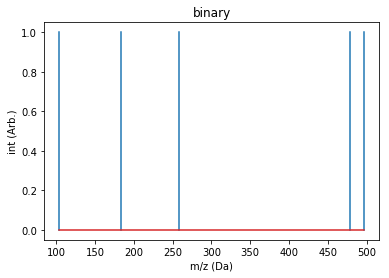

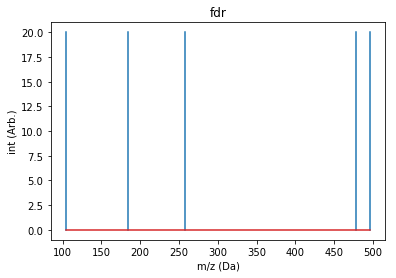

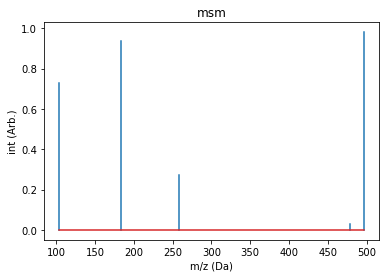

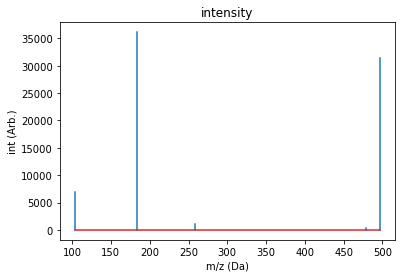

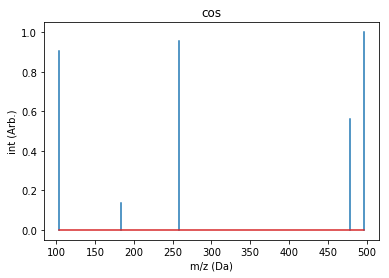

In [34]:
to_print = {'binary': test_bin, 'fdr': test_fdr, 'msm': test_msm,
           'intensity': test_int, 'cos': test_cos}
for title, spectra in to_print.items():
    print(plot_spectra(spectra, title))

In [35]:
20000-19470.86


529.1399999999994

In [ ]:
# 11. Compare predicted, experimental, and psuedo-MS/MS spectra.

In [ ]:
df1 = pd.DataFrame()
df1['path_1'] = glob.glob(ref_expt_pos + '/**/*.ms', recursive=True)
df1['name'] = df1.path_1.apply(lambda x: x.split("/")[-1])

df2 = pd.DataFrame()
df2['path_2'] = glob.glob(ref_theo_pos + '/**/*.ms', recursive=True)
df2['name'] = df2.path_2.apply(lambda x: x.split("/")[-1])

df_pos = df1.merge(df2, how='outer', on='name')

In [ ]:
df1 = pd.DataFrame()
df1['path_1'] = glob.glob(ref_expt_neg + '/**/*.ms', recursive=True)
df1['name'] = df1.path_1.apply(lambda x: x.split("/")[-1])

df2 = pd.DataFrame()
df2['path_2'] = glob.glob(ref_theo_neg + '/**/*.ms', recursive=True)
df2['name'] = df2.path_2.apply(lambda x: x.split("/")[-1])

df_neg = df1.merge(df2, how='outer', on='name')

In [ ]:
df_neg.head(4)

In [ ]:
# 12. Plot examples.

In [33]:
def plot_spectra(list_tup, title, invert_y=False):
    mzs = [x[0] for x in list_tup]
    
    if invert_y == False:
        ints = [x[1] for x in list_tup]
    else:
        ints = [x[1]*-1 for x in list_tup]
    
    
    fig, ax = plt.subplots()
    ax.stem(mzs, ints ,markerfmt=' ')
    plt.title(title)
    plt.xlabel('m/z (Da)')
    plt.ylabel('int (Arb.)')
    return fig, ax

In [ ]:
m = df_pos.sort_values(by=['cos'], ascending=False).iloc[0,:].path_1

In [ ]:
# 12. Pick winners and carry well-behaved molecules forward.
hits = []
well_behaved_hits = cm3_stds_df[cm3_stds_df.id.isin(hits)].copy(deep=True)
well_behaved_hits.to_pickle('intermediate/val_spotted.pickle')